In [1]:
##################################
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd 
import numpy as np
import random
##################################

In [2]:
df = pd.read_csv("bank.csv")
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


In [3]:
sampled = df.sample(1000)
sampled.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
2176,28,blue-collar,single,secondary,no,-46,yes,no,cellular,1,sep,199,1,92,14,success,yes
3524,45,services,married,secondary,no,0,no,yes,cellular,8,jul,47,7,-1,0,unknown,no
3969,40,self-employed,married,primary,no,92,yes,no,unknown,13,may,92,1,-1,0,unknown,no
630,30,management,single,tertiary,no,2,yes,yes,cellular,25,jul,1031,8,-1,0,unknown,yes
2504,35,blue-collar,married,secondary,no,280,yes,yes,cellular,31,jul,65,50,-1,0,unknown,no


In [4]:
new_df = np.array(sampled[['age','balance']])
new_df

array([[  32,  101],
       [  56, 2190],
       [  31,  757],
       ...,
       [  40,   92],
       [  30,    2],
       [  35,  280]], dtype=int64)

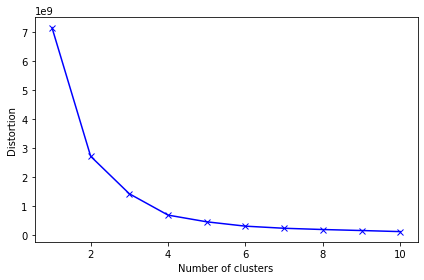

In [5]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(new_df)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()

plt.show()

In [6]:
df = pd.read_csv("bank.csv")
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


In [7]:
sampled = df.sample(1000)
sampled.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1478,35,technician,single,tertiary,no,7546,yes,no,cellular,28,dec,137,1,122,3,failure,no
3703,42,blue-collar,married,primary,no,-97,yes,no,cellular,3,feb,216,4,271,5,failure,no
4221,47,technician,married,unknown,no,2106,yes,no,unknown,6,may,168,1,-1,0,unknown,no
3728,53,technician,married,secondary,no,0,no,no,cellular,22,aug,77,9,-1,0,unknown,no
3215,40,technician,married,secondary,no,990,yes,no,cellular,6,feb,252,3,-1,0,unknown,no


In [8]:
new_df = np.array(sampled[['age','balance']])
new_df

array([[  33,    0],
       [  26,   -3],
       [  28,    0],
       ...,
       [  47, 2106],
       [  53,    0],
       [  40,  990]], dtype=int64)

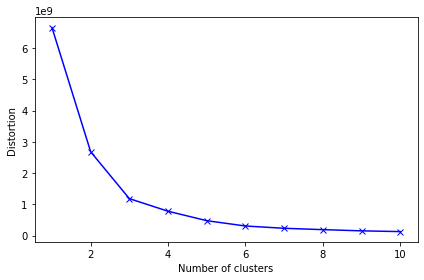

In [9]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(new_df)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()

plt.show()